In [2]:
from collections.abc import Iterable
import datetime as dt

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import seaborn as sns

import covidcast

In [3]:
CENSUS_REGIONS = {
    "Northeast": ["ct", "me", "ma", "nh", "ri", "vt", "nj", "ny", "pa"],
    "Midwest": ["in", "il", "mi", "oh", "wi", "ia", "ks", "mn", "mo", "ne", "nd", "sd"],
    "South": ["de", "dc", "fl", "ga", "md", "nc", "sc", "va", "wv", "al", "ky", "ms", "tn",
              "ar", "la", "ok", "tx"],
    "West": ["az", "co", "id", "nm", "mt", "ut", "nv", "wy", "ak", "ca", "hi", "or", "wa"]
}

STATE_TO_CENSUS_REGION = {
    state: region for region, states in CENSUS_REGIONS.items() for state in states 
}

# Healthcare, Retail, Restaurant, Others
OCCUP_CAT = {
    1: "Others",
    2: "Others",
    3: "Others",
    4: "Healthcare",
    5: "Healthcare",
    6: "Others",
    7: "Restaurant",
    8: "Others",
    9: "Others",
    10: "Retail",
    11: "Others",
    12: "Others",
    13: "Others",
    14: "Others",
    15: "Others",
    16: "Others",
}

In [3]:
API_SIGNALS = {
    ("fb-survey", "raw_cli"): "CLI",
    ("fb-survey", "raw_nohh_cmnty_cli"): "CLI-in-community",
    ("jhu-csse", "confirmed_incidence_prop"): "Cases",
    ("hhs", "confirmed_admissions_covid_1d"): "Hospitalizations",
    ("jhu-csse", "deaths_incidence_prop"): "Deaths",
}

START_DATE = dt.date(2020, 4, 6)
END_DATE = dt.date(2021, 4, 5)

# Fetch all signals
dfs = []
for (source, signal), name in API_SIGNALS.items():
    print(f"Downloading {name}")
    df = covidcast.signal(
        source, signal,
        START_DATE, END_DATE,
        geo_type="state")
    df["signal"] = name
    dfs.append(df)
df_all_raw = pd.concat(dfs)

# Census Region
df_all_raw["region"] = df_all_raw.geo_value.map(STATE_TO_CENSUS_REGION)

# Join state population sizes
df_state_pop = pd.read_csv("state_pop.csv", dtype={"state_code": str})
df_all_raw = df_all_raw.merge(df_state_pop, left_on="geo_value", right_on="state_id")

df_hhs = df_all_raw.loc[df_all_raw.data_source == "hhs", :]
df_all_raw.loc[df_all_raw.data_source == "hhs", "value"] = df_hhs["value"] / df_hhs["pop"] * 100000

# Aggregation weights
df_all_raw["weight"] = np.where(
    df_all_raw.data_source.isin(["jhu-csse", "hhs"]),
    df_all_raw["pop"],
    df_all_raw["sample_size"])

/home/eujing/.pyenv/versions/3.8.6/envs/delphi/lib/python3.8/site-packages/covidcast/covidcast.py:411: NoDataWarning: No fb-survey raw_nohh_cmnty_cli data found on 20200406 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/home/eujing/.pyenv/versions/3.8.6/envs/delphi/lib/python3.8/site-packages/covidcast/covidcast.py:411: NoDataWarning: No fb-survey raw_nohh_cmnty_cli data found on 20200407 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/home/eujing/.pyenv/versions/3.8.6/envs/delphi/lib/python3.8/site-packages/covidcast/covidcast.py:411: NoDataWarning: No fb-survey raw_nohh_cmnty_cli data found on 20200408 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/home/eujing/.pyenv/versions/3.8.6/envs/delphi/lib/python3.8/site-packages/covidcast/covidcast.py:411: NoDataWarning: No fb-survey raw_nohh_cmnty_cli data found on 20200409 for geography 'state'
  warnings

/home/eujing/.pyenv/versions/3.8.6/envs/delphi/lib/python3.8/site-packages/covidcast/covidcast.py:411: NoDataWarning: No hhs confirmed_admissions_covid_1d data found on 20200406 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/home/eujing/.pyenv/versions/3.8.6/envs/delphi/lib/python3.8/site-packages/covidcast/covidcast.py:411: NoDataWarning: No hhs confirmed_admissions_covid_1d data found on 20200407 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/home/eujing/.pyenv/versions/3.8.6/envs/delphi/lib/python3.8/site-packages/covidcast/covidcast.py:411: NoDataWarning: No hhs confirmed_admissions_covid_1d data found on 20200408 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "


In [4]:
def weighted_avg(col, weight_col="weight"):
    '''Weighted estimate of a binomial proportion for use with .apply()'''
    
    def wavg(df):
        missing = df[col].isna()
        x = df.loc[~missing, col].astype(np.float64)
        w = df.loc[~missing, weight_col]
        
        if len(x) == 0:
            return np.nan
        
        return np.average(x, weights=w)
    
    return wavg

def weighted_se(col, weight_col="weight"):
    '''Weighted standard error of a binomial proportion for use with .apply()'''
    
    def wse(df):
        missing = df[col].isna()
        x = df.loc[~missing, col].astype(np.float64)
        w = df.loc[~missing, weight_col]
        
        if len(x) == 0:
            return np.nan
        
        p = np.average(x, weights=w)
        w /= np.sum(w)
        w2 = np.sum(w**2)
        wvar = p * (1 - p) * w2
        
        return np.sqrt(wvar)
    
    return wse

def multi_contains(responses, val, split_char=","):
    selected = responses.str.split(split_char)
    val = str(val)
    
    def contains_vals(selected_opts):
        if isinstance(selected_opts, Iterable):
            return val in selected_opts
        else:
            return np.nan
        
    return selected.apply(contains_vals)

df_unified = pd.concat([
    pd.read_csv(
        file,
        # To save memory
        usecols=["StartDatetime", "EndDatetime", "fips", "weight", "wave",
                 "B2", "B8", "B10a", "B11", "C13",
                 "D8", "Q64"],
        dtype={"fips": str},
        parse_dates=["StartDatetime", "EndDatetime"])
    for file in ["unified-1-year-part-1.csv.gz", "unified-1-year-part-2.csv.gz"]])

df_unified["date"] = df_unified.StartDatetime.dt.normalize()
df_unified["state_code"] = df_unified.fips.str[:2]

# Groups
df_unified["epoch"] = pd.cut(
    df_unified.date,
    pd.to_datetime(['2020-09-01', '2020-11-01', '2021-01-01']),
    right=False)
df_unified["occupation_category"] = df_unified.Q64.map(OCCUP_CAT)

# Booleans
df_unified["worked_outside_home"] = multi_contains(df_unified.C13, "1")
df_unified["tested"] = (df_unified.B8 == 1)
df_unified["positive_test"] = (df_unified.B10a == 1) | (df_unified.B11 == 1)
df_unified["anosmia"] = multi_contains(df_unified.B2, "13")

/home/eujing/.pyenv/versions/3.8.6/envs/delphi/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (62) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/home/eujing/.pyenv/versions/3.8.6/envs/delphi/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (49) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [5]:
gdf = (df_unified
 .rename(columns={"date": "time_value"})
 .groupby(["time_value", "state_code"]))

df_anosmia = pd.concat([
    100 * gdf.apply(weighted_avg("anosmia")).rename("value"),
    100 * gdf.apply(weighted_se("anosmia")).rename("stderr"),
    gdf.size().rename("sample_size"),
], axis=1).reset_index()

df_anosmia = df_anosmia.merge(df_state_pop, on="state_code")
df_anosmia["geo_value"] = df_anosmia["state_id"]
df_anosmia["signal"] = "Anosmia"
df_anosmia["issue"] = df_anosmia["time_value"]
df_anosmia["lag"] = 0
df_anosmia["geo_type"] = "state"
df_anosmia["data_source"] = "fb-survey"
df_anosmia["region"] = df_anosmia.state_id.map(STATE_TO_CENSUS_REGION)
df_anosmia["weight"] = df_anosmia["sample_size"]
df_anosmia = df_anosmia[df_all_raw.columns]

In [6]:
df_ct = pd.read_csv("https://api.covidtracking.com/v1/states/daily.csv", parse_dates=["date"])
df_ct = (df_ct
         .loc[df_ct.date.between(pd.to_datetime(START_DATE), pd.to_datetime(END_DATE)), ["date", "state", "hospitalizedCurrently"]]
         .rename(columns={"date": "time_value", "state": "state_id", "hospitalizedCurrently": "value"}))

df_ct["state_id"] = df_ct.state_id.str.lower()
df_ct["geo_value"] = df_ct["state_id"]
df_ct = df_ct.merge(df_state_pop, on="state_id")

df_ct["signal"] = "Current Hospitalizations"
df_ct["issue"] = df_ct["time_value"]
df_ct["lag"] = 0
df_ct["geo_type"] = "state"
df_ct["data_source"] = "covid-tracking"
df_ct["region"] = df_ct.state_id.map(STATE_TO_CENSUS_REGION)
df_ct["weight"] = df_ct["pop"]
df_ct["value"] = df_ct["value"] / df_ct["pop"] * 100000

df_ct.head()

,time_value,state_id,value,geo_value,state_code,state_name,pop,signal,issue,lag,geo_type,data_source,region,weight
0,2021-03-07,ak,4.511001,ak,02,Alaska,731545,Current Hospitalizations,2021-03-07,0,state,covid-tracking,West,731545
1,2021-03-06,ak,4.511001,ak,02,Alaska,731545,Current Hospitalizations,2021-03-06,0,state,covid-tracking,West,731545
2,2021-03-05,ak,4.511001,ak,02,Alaska,731545,Current Hospitalizations,2021-03-05,0,state,covid-tracking,West,731545
3,2021-03-04,ak,4.374304,ak,02,Alaska,731545,Current Hospitalizations,2021-03-04,0,state,covid-tracking,West,731545
4,2021-03-03,ak,3.554122,ak,02,Alaska,731545,Current Hospitalizations,2021-03-03,0,state,covid-tracking,West,731545


## Figure 1: Symptoms

Plot outcomes over time (full time series April-Dec): CLI, CLI-in-community, reported cases, hospitalizations, deaths. Stratification by census region is a possibility, so it could be a 4 by 5 grid of plots:
Rows are census regions
Columns are CLI, CLI-in-community, cases, hospitalizations, deaths
Or if we also wanted to show some states, we could have one row of plots with multiple lines in each plot (one per census region), and perhaps a second row with selected states (those with highest cumulative per capita infections, e.g?).

**Notes:**
- For geo-aggregating from state -> census region, weights used are `sample_size` for `fb-survey` signals and `pop` (state population) for `jhu-csse` and `hhs` signals.
- Raw state-level signals are fetched from the API, aggregated as above, then smoothed with a 7-day-average.
- Hospitalizations data only start in mid-July 2020 for most states.
- Case and death incidence proportions might be negative, especially towards end of year.

**Current Signals Used:**

| Source | Signal | Outcome |
|--------|--------|---------|
| `fb-survey` | `raw_cli` | CLI |
| `fb-survey` | `raw_nohh_cmnty_cli` | CLI |
| `jhu-csse` | `confirmed_incidence_prop` | Cases |
| `jhu-csse` | `deaths_incidence_prop` | Deaths |
| `hhs` | `confirmed_admissions_covid_1d` | Hospitalizations |
| Unified data | `B2` contains "13" | Anosmia |

In [7]:
# Aggregations
df_all_agg = (pd.concat([df_all_raw, df_anosmia, df_ct])
              
              # Geo-aggregate to census region by appropriate weights
              .groupby(["region", "signal", "time_value"])
              .apply(weighted_avg("value"))
              .rename("value")
              .reset_index()
              
              # 7-day-average smoothing
              .groupby(["region", "signal"])
              .rolling(7, on="time_value").mean()
              .reset_index())

df_all_raw_nonneg = pd.concat([df_all_raw, df_anosmia, df_ct])
jhu = df_all_raw_nonneg.data_source == "jhu-csse"
df_all_raw_nonneg.loc[jhu, "value"] = df_all_raw_nonneg.loc[jhu, "value"].clip(lower=0)

df_all_agg_nonneg = (df_all_raw_nonneg
              
              # Geo-aggregate to census region by appropriate weights
              .groupby(["region", "signal", "time_value"])
              .apply(weighted_avg("value"))
              .rename("value")
              .reset_index()
              
              # 7-day-average smoothing
              .groupby(["region", "signal"])
              .rolling(7, on="time_value").mean()
              .reset_index())

## Figure 1: By Census Regions

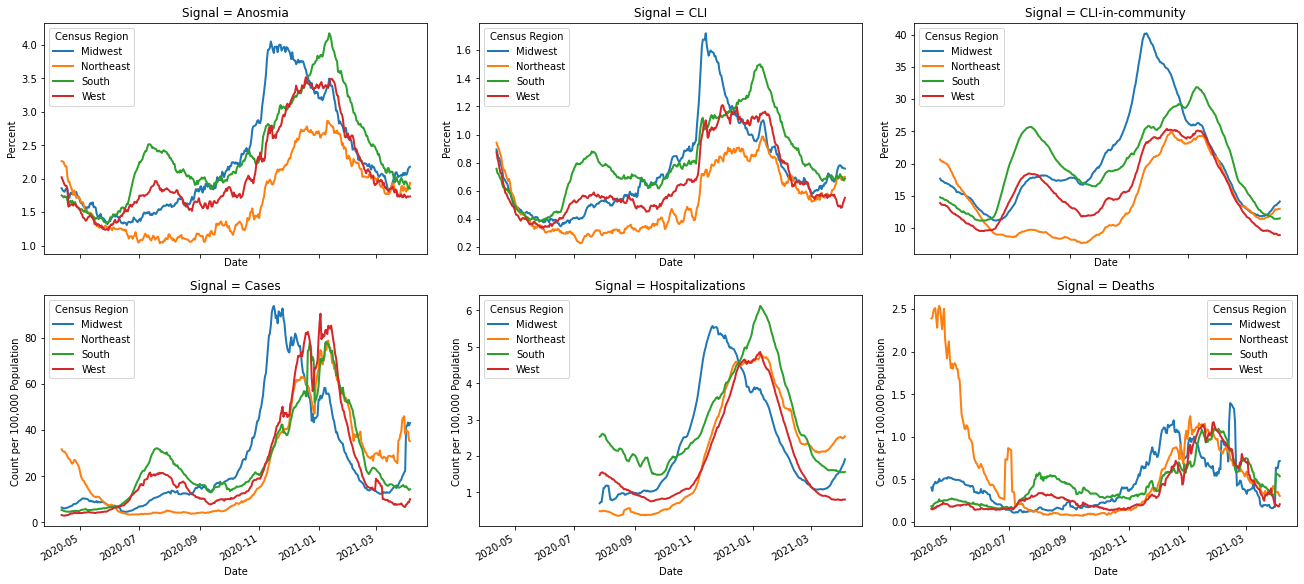

In [8]:
def plot_fig_1_2(df_agg, col_wrap=3, col_order=None, ylabels=None):
    if col_order is None:
        cols = df_agg.signal.unique()
    else:
        cols = col_order
    
    nrows = int(len(cols) / col_wrap + 0.5)
    ncols = col_wrap

    fig, axs = plt.subplots(
        nrows, ncols,
        figsize=(6*ncols, 4*nrows),
        constrained_layout=True,
        sharex="all", squeeze=False)

    axs_map = {}
    for i in range(len(cols)):
        col_idx = i % col_wrap
        row_idx = i // col_wrap
        axs_map[cols[i]] = axs[row_idx, col_idx] 

    for signal, ax in axs_map.items():
        # Plot smoothed aggregated
        df = df_agg.query("signal == @signal")
        for region, sub_df in df.groupby("region"):
            ax.plot(
                "time_value", "value",
                data=sub_df, linewidth=2, label=region)

        # Formatting
        ax.legend(title="Census Region")
        ax.set(xlabel="Date", 
               ylabel="Value",
               title=f"{signal}")
        for label in ax.get_xticklabels():
            label.set_ha("right")
            label.set_rotation(30)
            
    return fig, axs

fig, axs = plot_fig_1_2(
    df_all_agg_nonneg.query("signal != 'Hospitalizations' or time_value >= '2020-07-27'"),
    col_wrap=3, col_order=[
        "Anosmia", "CLI", "CLI-in-community",
        "Cases",
        "Hospitalizations",
#         "Current Hospitalizations",
        "Deaths",
    ])

axs[0, 0].set(ylabel="Percent")
axs[0, 1].set(ylabel="Percent")
axs[0, 2].set(ylabel="Percent")
axs[1, 0].set(ylabel="Count per 100,000 Population")
axs[1, 1].set(ylabel="Count per 100,000 Population")
axs[1, 2].set(ylabel="Count per 100,000 Population")

plt.show()

In [9]:
# To check when to left-truncate HHS hospitalizations data
counts = (df_all_raw_nonneg
 .query("signal == 'Hospitalizations' and time_value >= '2020-07-01'")
 .sort_values("time_value")
 .groupby("time_value")["geo_value"]
 .count())

counts.head(30)

time_value
2020-07-01     5
2020-07-02     4
2020-07-03     3
2020-07-04     4
2020-07-05     4
2020-07-06     6
2020-07-07     6
2020-07-08     5
2020-07-09     7
2020-07-10     6
2020-07-11     6
2020-07-12     5
2020-07-13     6
2020-07-14    51
2020-07-15    51
2020-07-16    51
2020-07-17    51
2020-07-18    51
2020-07-19    51
2020-07-20    52
2020-07-21    52
2020-07-22    50
2020-07-23    50
2020-07-24    51
2020-07-25    51
2020-07-26    51
2020-07-27    53
2020-07-28    53
2020-07-29    53
2020-07-30    53
Name: geo_value, dtype: int64